In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import peak_widths, find_peaks
from scipy.stats import cauchy, binom, norm
from scipy.optimize import curve_fit
import allantools
import sys
sys.path.append('./')
from simul_utils import *
import pandas as pd
import os
from importlib import reload

### Zeeman pair lineshapes

(-0.02, 0.65)

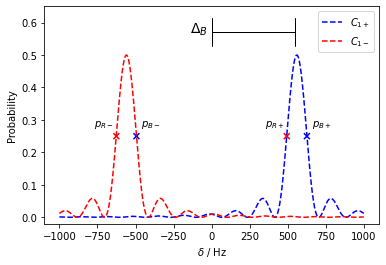

In [24]:
zeeman_coeff = 5.6 # Hz/nT
linear_zeeman = lambda B: zeeman_coeff*B
deltas = np.linspace(-1000, 1000, 1000)
center = 0.
B = 100
tau_pi = 6e-3
peak_p = lineshape(deltas, 6e-3, False, center=center+linear_zeeman(B))
peak_m = lineshape(deltas, 6e-3, False, center=center-linear_zeeman(B))
HWHM = FWHM(peak_p, deltas)/2.
peaks = peak_p + peak_m
plt.plot(deltas, peak_p, linestyle='--', color='b', label=r"$C_{1+}$")
plt.plot(deltas, peak_m, linestyle='--', color='r', label=r"$C_{1-}$")
p_deltas = [center-linear_zeeman(B)-HWHM, center-linear_zeeman(B)+HWHM, center+linear_zeeman(B)-HWHM, center+linear_zeeman(B)+HWHM]
plt.scatter(p_deltas, 
            [.25]*4, c=['r', 'b', 'r', 'b'], marker='x')
p_annots = [r'$p_{R-}$', r'$p_{B-}$', r'$p_{R+}$', r'$p_{B+}$']
annot_offsets = [(-22, 10), (5, 10), (-22, 10), (5, 10)]
for i, txt in enumerate(p_annots):
    plt.annotate(txt, (p_deltas[i], 0.25), xytext=annot_offsets[i], textcoords='offset points')
plt.annotate(r'$\Delta_B$', xy=(linear_zeeman(B), .57), xytext=(-140, .57),
             xycoords='data', fontsize=14,
             textcoords='data', arrowprops={'arrowstyle': '|-|',
                                            'connectionstyle': 'angle',
                                            'ec':'k'})
plt.legend()
plt.xlabel(r"$\delta$ / Hz")
plt.ylabel("Probability")
plt.ylim([-0.02, 0.65])
#plt.savefig('../figs/BC_sampling_example.pdf', dpi=150)

### Servo algorithm sensitivity to error

R+: 0.01163801299998157, R-: 0.426022606331503, B+: 0.2527958270970243, B-: 0.2527958270970243
B discriminant: 0.4393147039897427 (-49.55 Hz offset), LC discriminant: 0.07201788616810069 (49.55 Hz offset)


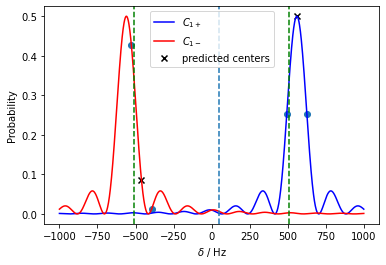

In [3]:
zeeman_coeff = 5.6 # Hz/nT
linear_zeeman = lambda B: zeeman_coeff*B
deltas = np.linspace(-1000, 1000, 1000)
center = 0.
B = 100
tau_pi = 6e-3
peak_p = lineshape(deltas, tau_pi, False, center=center+linear_zeeman(B))
peak_m = lineshape(deltas, tau_pi, False, center=center-linear_zeeman(B))
HWHM = FWHM(peak_p, deltas)/2.
peaks = peak_p + peak_m
plt.plot(deltas, peak_p, color='b', label=r"$C_{1+}$")
plt.plot(deltas, peak_m, color='r', label=r"$C_{1-}$")
d_L = .75*HWHM
d_B = -.75*HWHM
plt.axvline(d_L, linestyle='--')
plt.axvline(d_B+linear_zeeman(B), linestyle='--', color='g')
plt.axvline(-d_B-linear_zeeman(B), linestyle='--', color='g')
centers = [lineshape(d_L-d_B-linear_zeeman(B), tau_pi, False, center=center-linear_zeeman(B)),
           lineshape(d_L+d_B+linear_zeeman(B), tau_pi, False, center=center+linear_zeeman(B))]
plt.scatter([d_L-d_B-linear_zeeman(B), d_L+d_B+linear_zeeman(B)], centers,
           marker='x', color='k', label='predicted centers')
plt.legend()
plt.xlabel(r"$\delta$ / Hz")
plt.ylabel("Probability")
p_pR = lineshape(d_L-d_B-linear_zeeman(B)+HWHM, tau_pi, False, center=center-linear_zeeman(B))
p_mR = lineshape(d_L-d_B-linear_zeeman(B)-HWHM, tau_pi, False, center=center-linear_zeeman(B))
p_pB = lineshape(d_L+d_B+linear_zeeman(B)+HWHM, tau_pi, False, center=center+linear_zeeman(B))
p_mB = lineshape(d_L+d_B+linear_zeeman(B)-HWHM, tau_pi, False, center=center+linear_zeeman(B))
plt.scatter([d_L-d_B-linear_zeeman(B)+HWHM,d_L-d_B-linear_zeeman(B)-HWHM,d_L+d_B+linear_zeeman(B)+HWHM,d_L+d_B+linear_zeeman(B)-HWHM],
            [p_pR, p_mR, p_pB, p_mB])
print(f'R+: {p_pR}, R-: {p_mR}, B+: {p_pB}, B-: {p_mB}')
p_sep1 = p_pB + p_mR
p_sep2 = p_mB + p_pR
discriminant_B = np.divide(p_sep1 - p_sep2, p_sep1 + p_sep2)
pfb_1 = p_mR+p_pR
pfb_2 = p_mB+p_pB
discriminant_LC = (pfb_2 - pfb_1) / (pfb_2 + pfb_1)
print(f'B discriminant: {discriminant_B} ({d_B:.2f} Hz offset), LC discriminant: {discriminant_LC} ({d_L:.2f} Hz offset)')

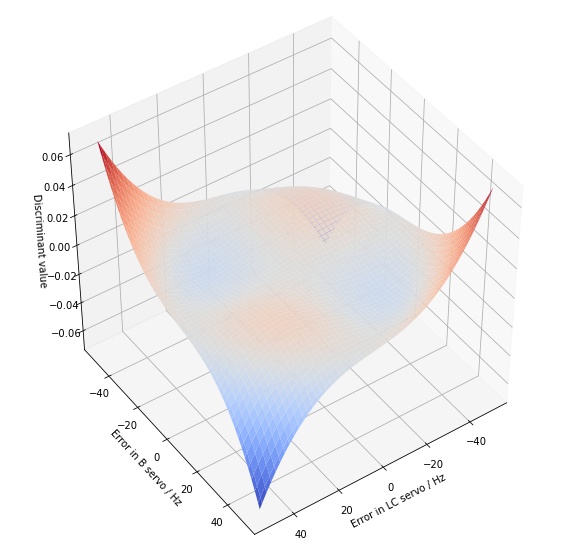

In [10]:
zeeman_coeff = 5.6 # Hz/nT
linear_zeeman = lambda B: zeeman_coeff*B
deltas = np.linspace(-1000, 1000, 1000)
e_range = 50
centers = np.linspace(-e_range, e_range, 100)
center = 0.
B = 100.
z_s = linear_zeeman(B)
seps = np.linspace(z_s-e_range, z_s+e_range, 100)
tau_pi = 6e-3
peak_p = lineshape(deltas, tau_pi, False, center=z_s)
HWHM = FWHM(peak_p, deltas)/2.
centers, seps = np.meshgrid(centers, seps)
p_pR = lineshape(centers-seps+HWHM, tau_pi, False, center=center-linear_zeeman(B))
p_mR = lineshape(centers-seps-HWHM, tau_pi, False, center=center-linear_zeeman(B))
p_pB = lineshape(centers+seps+HWHM, tau_pi, False, center=center+linear_zeeman(B))
p_mB = lineshape(centers+seps-HWHM, tau_pi, False, center=center+linear_zeeman(B))
p_sep1 = p_pB + p_mR
p_sep2 = p_mB + p_pR
discriminant_B = p_sep1 - p_sep2
pfb_1 = p_pB+p_mB
pfb_2 = p_pR+p_mR
discriminant_LC = (pfb_1-pfb_2)
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(centers, seps-z_s, discriminant_LC, cmap='coolwarm')
ax.set_xlabel(r'Error in LC servo / Hz')
ax.set_ylabel(r'Error in B servo / Hz')
ax.set_zlabel(r'Discriminant value')
# draw HWHM circle
theta = np.linspace(0, 2*np.pi)
x = HWHM*np.cos(theta)
y = HWHM*np.sin(theta)
#ax.plot(x,y)
ax.view_init(45, 55)

Text(0.5, 0, 'Discriminant value')

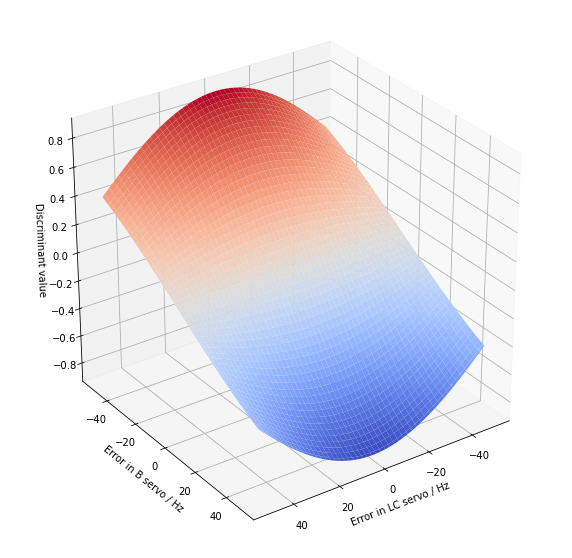

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(centers, seps-z_s, discriminant_B, cmap='coolwarm')
ax.view_init(30, 55)
ax.set_xlabel(r'Error in LC servo / Hz')
ax.set_ylabel(r'Error in B servo / Hz')
ax.set_zlabel(r'Discriminant value')

### Zeeman peak separation discriminant function

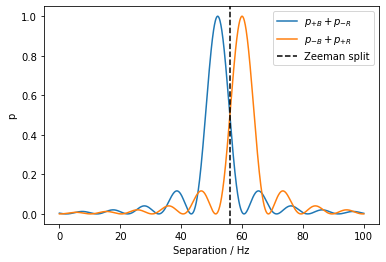

In [18]:
seps = np.linspace(0, 100, 1000)
deltas = np.linspace(-100, 100, 1000)
tau_pi = 100e-3
B = 10.
z_s = linear_zeeman(B)
HWHM = FWHM(lineshape(deltas, tau_pi, center=linear_zeeman(B)), deltas)/2.
pfb_pB = lineshape(HWHM+seps, tau_pi, center=z_s)
pfb_mB = lineshape(HWHM-seps, tau_pi, center=-z_s)
pfb_pR = lineshape(-HWHM+seps, tau_pi, center=z_s)
pfb_mR = lineshape(-HWHM-seps, tau_pi, center=-z_s)
p_sep1 = pfb_pB + pfb_mR
p_sep2 = pfb_mB + pfb_pR
plt.plot(seps, p_sep1, label=r'$p_{+B}+p_{-R}$')
plt.plot(seps, p_sep2, label=r'$p_{-B}+p_{+R}$')
plt.axvline(z_s, label='Zeeman split', color='k', linestyle='--')
plt.xlabel('Separation / Hz')
plt.ylabel('p')
plt.legend()

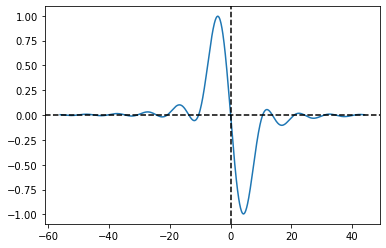

In [19]:
plt.plot(seps-z_s, p_sep1-p_sep2) 
plt.axvline(0., color='k', linestyle='--')
plt.axhline(0., color='k', linestyle='--')

### Line center lineshapes and discriminant

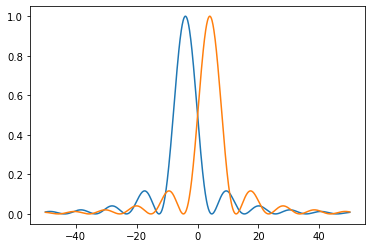

In [20]:
delta = np.linspace(-50, 50, 1000)
z_s = linear_zeeman(B)
pfb_pB = lineshape(z_s + HWHM + delta, tau_pi, center=z_s)
pfb_mB = lineshape(-z_s + HWHM + delta, tau_pi, center=-z_s)
pfb_pR = lineshape(z_s - HWHM + delta, tau_pi, center=z_s)
pfb_mR = lineshape(-z_s - HWHM + delta, tau_pi, center=-z_s)
pfb_1 = pfb_pB+pfb_mB
pfb_2 = pfb_pR+pfb_mR
plt.plot(delta,pfb_1)
plt.plot(delta,pfb_2)

Text(0.5, 0, 'Error in linecenter or z-shift (Hz)')

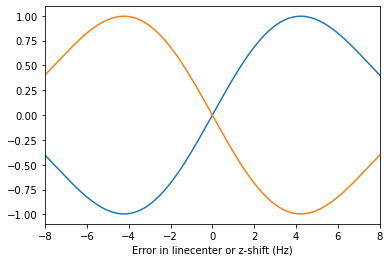

In [23]:
plt.plot(delta, pfb_2 - pfb_1)
plt.plot(seps-z_s, p_sep1-p_sep2)
plt.xlim([-0.8/tau_pi, 0.8/tau_pi])
plt.xlabel("Error in linecenter or z-shift (Hz)")

## Bichromatic simulation
### Set-up

B servo gain: 5.27 Hz, LC servo gain: 5.27 Hz


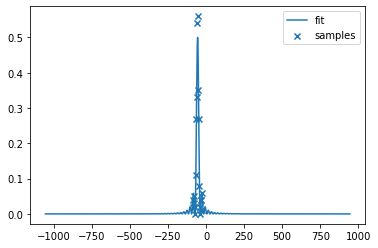

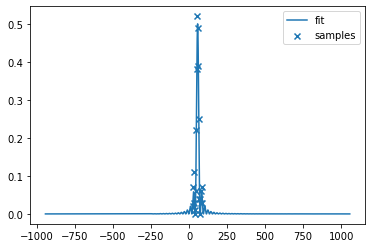

In [29]:
center = 0. # Hz, relative transition frequency
B = 10 # nT, magnetic field strength
B_drift = 1./3600 # nT/s, B-field drift
zeeman_coeff = 5.6 # Hz/nT, Zeeman peak coefficient
linear_zeeman = lambda B: zeeman_coeff*B
z_s = linear_zeeman(B) # initial linear Zeeman shift
tau_pi = 50e-3 # Pi-pulse length
n_s = 100 # number of samples
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c # s, total sampling time
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=0, stop=max_tau+n_c*T_s, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_B = np.zeros(len(t)) # Zeeman peak separation servo
eta_C = np.zeros(len(t)) # Line center serco
B_field = np.zeros(len(t))
B_field[0] = B
d, step = np.linspace(-1000, 1000, 100000, retstep=True)
d_sample = np.linspace(-1000, 1000, 10)

# initialize centers, k_ps and gains
f_cavity = 0. # laser initially in the center
f_centers = np.zeros(n_c)
servo_gains = np.zeros(2)
fwhms = np.zeros(n_c)
coeffs = [-1,1]
taus = np.zeros(n_c)
for center in range(len(coeffs)):
    fit_object = sample_initial_values(z_s*coeffs[center], tau_pi, plot=True)
    fwhms[center] = fit_object['fit_FWHM']
    # save results to vector
    f_centers[center] = fit_object['fit_center']
    taus[center] = fit_object['fit_tau']
servo_gains = BC_servo_gains(f_centers, taus, fwhms)
k_ps = servo_gains['k_p']
servo_gains = servo_gains['servo_gains']
print(f"B servo gain: {servo_gains[0]:.2f} Hz, LC servo gain: {servo_gains[1]:.2f} Hz")
ps = np.zeros((len(t), 6)) # container for probabilites

### Run simulation

In [30]:
# initial values
v0 = {'LC_servo': np.mean(f_centers),
      'B_servo': np.mean(np.abs(f_centers)),
      'B_field': B,
      'Laser': 0.}
sim_object=run_BC_simulation(t, f_centers, tau_pi, fwhms, servo_gains, v0, laser_drift=laser_drift, B_drift=B_drift)

C:\data\simulation\simul_utils.py:309: RuntimeWarning: invalid value encountered in true_divide
  discriminant_B = np.divide(p_sep1 - p_sep2, p_sep1 + p_sep2)
C:\data\simulation\simul_utils.py:316: RuntimeWarning: invalid value encountered in double_scalars
  discriminant_LC = (pfb_1 - pfb_2) / (pfb_1 + pfb_2)
C:\Users\LSSLAU\AppData\Local\Programs\Python\Python38-32\lib\site-packages\scipy\stats\_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
C:\Users\LSSLAU\AppData\Local\Programs\Python\Python38-32\lib\site-packages\scipy\stats\_discrete_distns.py:46: RuntimeWarning: invalid value encountered in less_equal
  return (n >= 0) & (p >= 0) & (p <= 1)


ValueError: Domain error in arguments.

NameError: name 'sim_object' is not defined

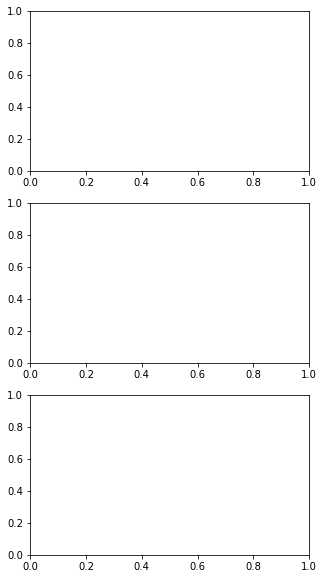

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
eta_corrected = sim_object['eta_C'] + sim_object['eta_cavity']
ax[0].scatter(t, eta_corrected, label='Corrected linecenter', marker='x')
B_corrected = sim_object['eta_B'] - linear_zeeman(sim_object['B_field'])
ax[0].scatter(t, B_corrected, label='Corrected mg-field', marker='x')
ax[0].axhline(np.mean(eta_corrected), color='k')
ax[0].axhline(np.mean(B_corrected), color='r')
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[0].legend()
ax[1].hist([eta_corrected, B_corrected], density=True, label=['Linecenter', 'Zeeman'])
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
ax[1].legend()
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.5, k_ps[1], f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="LC")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

In [15]:
fwhms

array([10.2010201 , 10.80108011])

### Effect of $\tau_\pi$

B servo gain: 5.23 Hz, LC servo gain: 5.25 Hz
B servo gain: 2.90 Hz, LC servo gain: 2.92 Hz
B servo gain: 2.12 Hz, LC servo gain: 2.07 Hz
B servo gain: 1.62 Hz, LC servo gain: 1.57 Hz
B servo gain: 1.33 Hz, LC servo gain: 1.34 Hz


FloatingPointError: invalid value encountered in double_scalars

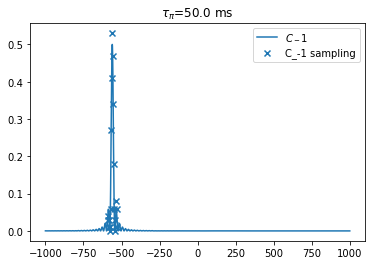

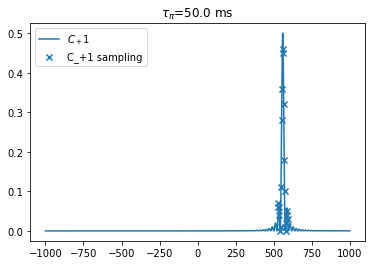

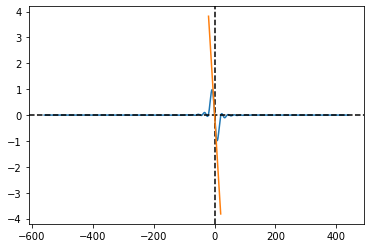

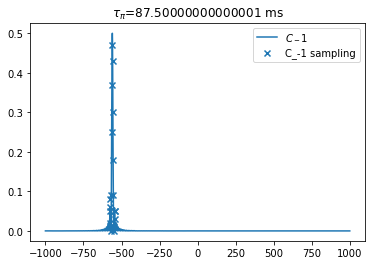

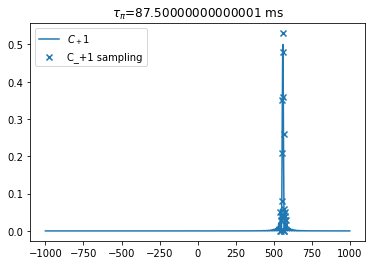

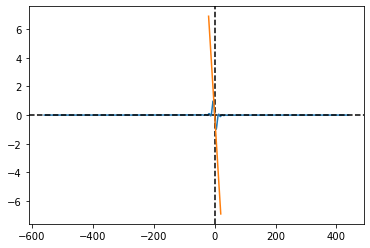

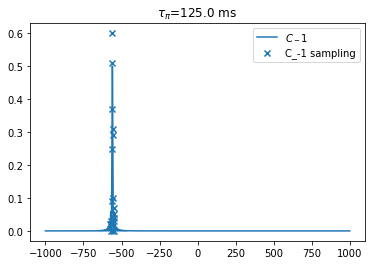

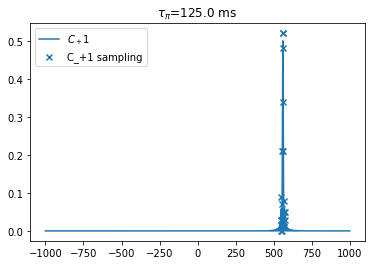

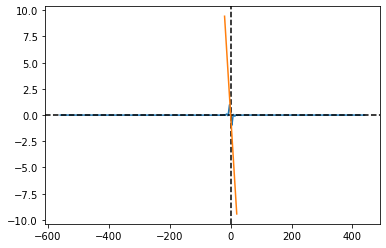

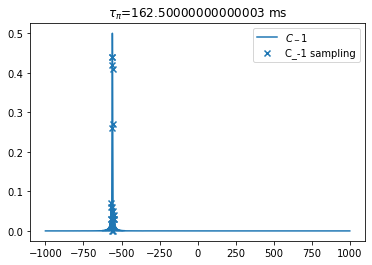

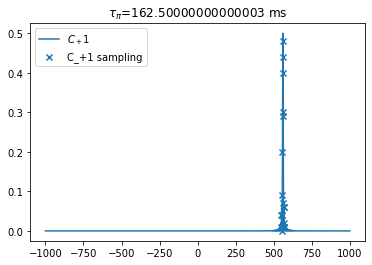

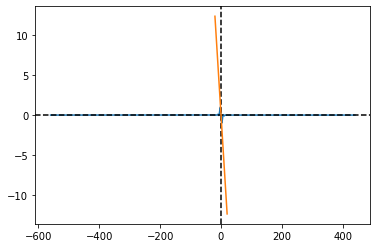

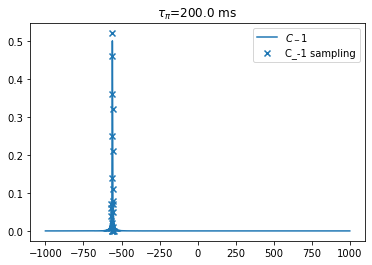

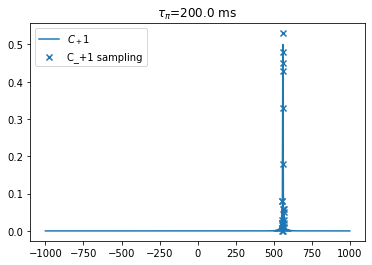

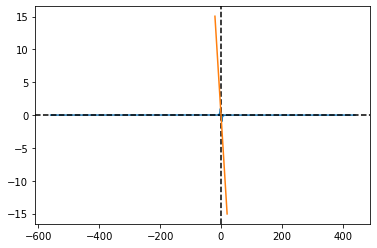

In [26]:
np.seterr("raise")
# initial values
B_drift = 1./3600 # nT/s, B-field drift
zeeman_coeff = 5.6 # Hz/nT, Zeeman peak coefficient
linear_zeeman = lambda B: zeeman_coeff*B
tau_pis = np.linspace(50e-3, 200e-3, 5) # Pi-pulse length
n_s = 100 # number of samples
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS

ts = []
eta_cavities = []
eta_Bs = []
eta_Cs = []
Bs = []

# run with different tau_pis
for ti in range(len(tau_pis)):
    center = 0. # Hz, relative transition frequency
    B = 100 # nT, magnetic field strength
    z_s = linear_zeeman(B) # initial linear Zeeman shift
    tau_pi = tau_pis[ti]
    T_c = 2*tau_pi # s, single cycle length
    T_s = n_s * T_c # s, total sampling time
    initial_offset = 0 # Hz
    t = np.arange(start=0, stop=max_tau+n_c*T_s, step=n_c*T_s)
    eta_cavity = np.zeros(len(t)) # cavity frequency
    eta_B = np.zeros(len(t)) # Zeeman peak separation servo
    eta_C = np.zeros(len(t)) # Line center serco
    B_field = np.zeros(len(t))
    B_field[0] = B
    d, step = np.linspace(-1000, 1000, 100000, retstep=True)

    # initialize centers, k_ps and gains
    f_cavity = 0. # laser initially in the center
    f_centers = np.zeros(n_c)
    servo_gains = np.zeros(2)
    fwhms = np.zeros(n_c)
    coeffs = [-1,1]
    taus = np.zeros(n_c)
    for center in range(len(coeffs)):
        fourier_limit = 0.8 / tau_pi
        d_sample = np.linspace(coeffs[center]*z_s-2.*fourier_limit, coeffs[center]*z_s+2.*fourier_limit, 20)
        # sample ideal lineshape
        l_sample = sampled_lineshape(lineshape, 
                                     d_sample,
                                     tau_pi=tau_pi,
                                     state_prep=state_preparation,
                                     samples_per_point=100,
                                     linecenter=coeffs[center]*z_s)
        # fit to sampled to simulate real measurement
        popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample,
                               l_sample, p0=[tau_pi, coeffs[center]*z_s])
        fit_shape = lineshape(d, popt[0], state_preparation, popt[1])
        fig1, ax1 = plt.subplots()
        ax1.plot(d,fit_shape,label=rf'$C_{coeffs[center]:+}$')
        # calculate FWHM
        width = peak_widths(fit_shape, [np.argmax(fit_shape)], rel_height=0.5)
        fwhms[center] = d[int(width[3][0])] - d[int(width[2][0])]
        # save results to vector
        f_centers[center] = popt[1]
        taus[center] = popt[0]
        ax1.scatter(d_sample, l_sample, marker='x', label=rf'C_{coeffs[center]:+} sampling')
        ax1.legend()
        ax1.set_title(rf'$\tau_\pi$={tau_pi*1e3} ms')
    # set up B servo
    eta_B[0] = np.mean(np.abs(f_centers))
    seps, sep_step = np.linspace(0, 1000, 10000, retstep=True)
    pB_pB = lineshape(fwhms[1]/2.+seps, taus[1], center=f_centers[1])
    pB_mB = lineshape(fwhms[0]/2.-seps, taus[0], center=f_centers[0])
    pB_pR = lineshape(-fwhms[1]/2.+seps, taus[1], center=f_centers[1])
    pB_mR = lineshape(-fwhms[0]/2.-seps, taus[0], center=f_centers[0])
    p_sep1 = pB_pB + pB_mR
    p_sep2 = pB_mB + pB_pR
    k_B = p_sep1 - p_sep2
    dk_B = np.diff(k_B) / sep_step
    k_pB = dk_B[np.argmin(np.abs(seps-eta_B[0]))]
    servo_gains[0] = -2 * 0.5/k_pB
    fig2, ax2 = plt.subplots()
    ax2.plot(seps-eta_B[0], k_B)
    ax2.axvline(0., color='k', linestyle='--')
    ax2.axhline(0., color='k', linestyle='--')
    ax2.plot(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)*k_pB)
    #set up LC servo
    pfb_pB = lineshape(f_centers[0] + fwhms[0]/2. + d, taus[0], center=f_centers[0])
    pfb_mB = lineshape(f_centers[1] + fwhms[1]/2. + d, taus[1], center=f_centers[1])
    pfb_pR = lineshape(f_centers[0] - fwhms[0]/2. + d, taus[0], center=f_centers[0])
    pfb_mR = lineshape(f_centers[1] - fwhms[1]/2. + d, taus[1], center=f_centers[1])
    pfb_1 = pfb_mB-pfb_mR
    pfb_2 = pfb_mB+pfb_pB
    k_C = pfb_mB-pfb_mR
    dk_C = np.diff(k_C) / step
    k_p_lc = dk_C[np.argmin(np.abs(d))]
    servo_gains[1] = (-2*0.25)/k_p_lc
    eta_C[0] = np.mean(f_centers)
    print(f"B servo gain: {servo_gains[0]:.2f} Hz, LC servo gain: {servo_gains[1]:.2f} Hz")
    ps = np.zeros((len(t), 6)) # container for probabilites
    
    for i in range(1, len(t)):
        tau = t[i]
        # sample probabilities. Laser drifts only once per pair as two sites are sampled simultaneously (is this a problem?)
        p_mB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]+fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=0.)
        p_pR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]-fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=laser_drift)
        p_pB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]+fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=0.)
        p_mR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]-fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=laser_drift)
    
        # Control B servo
        p_sep1 = p_pB + p_mR
        p_sep2 = p_mB + p_pR
        discriminant_B = np.divide(p_sep1 - p_sep2, p_sep1 + p_sep2)
        eta_B[i] = eta_B[i-1] + discriminant_B * servo_gains[0]
    
        # Control LC servo
        pfb_1 = p_mR+p_pR
        pfb_2 = p_mB+p_pB
        ps[i,:] = [p_mR, p_mB, p_pR, p_pB, pfb_1, pfb_2]
        discriminant_LC = (p_mB-p_mR) / (p_mB+p_mR)
        eta_C[i] = eta_C[i-1] + discriminant_LC * servo_gains[1]

        eta_cavity[i] = f_cavity

        # Drift mg-field
        B_field[i] = B_field[i-1] + B_drift
        z_s = linear_zeeman(B_field[i])
    ts += [t]
    eta_cavities += [eta_cavity]
    eta_Bs += [eta_B]
    eta_Cs += [eta_C]
    Bs += [B_field]

In [30]:
p_pB

0.02

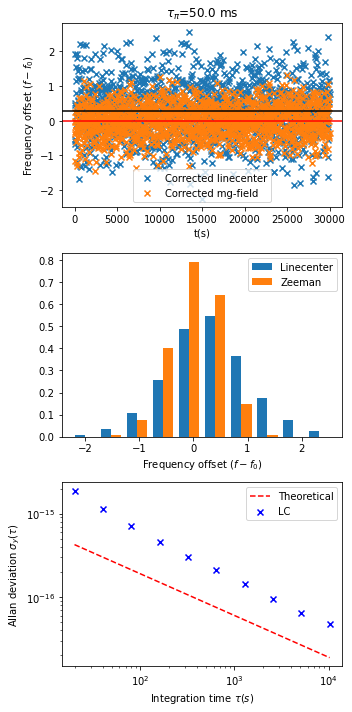

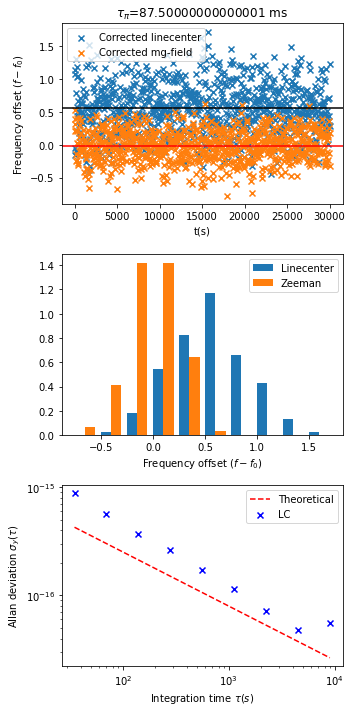

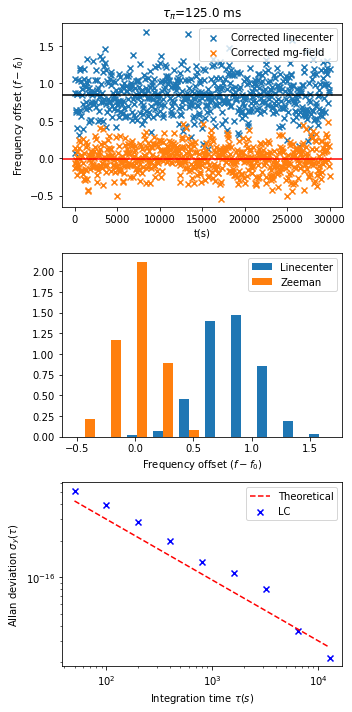

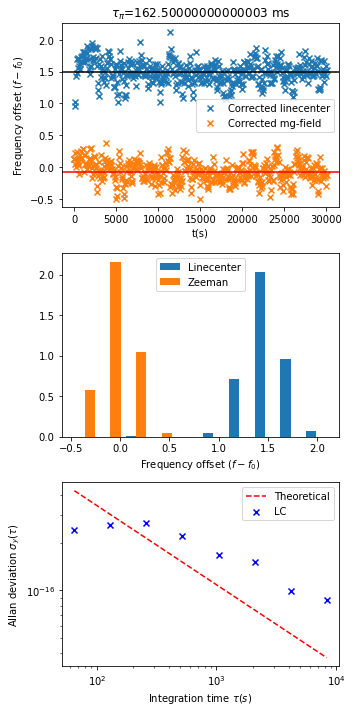

In [31]:
for t, eta_cavity, eta_C, eta_B, B_field, tau_pi in zip(ts, eta_cavities, eta_Cs, eta_Bs, Bs, tau_pis):
    T_c = 2*tau_pi # s, single cycle length
    T_s = n_s * T_c # s, total sampling time
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    eta_corrected = eta_C + eta_cavity
    ax[0].scatter(t, eta_corrected, label='Corrected linecenter', marker='x')
    ax[0].scatter(t, eta_B - linear_zeeman(B_field), label='Corrected mg-field', marker='x')
    ax[0].axhline(np.mean(eta_B - linear_zeeman(B_field)), color='r')
    ax[0].axhline(np.mean(eta_corrected), color='k')
    ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
    ax[0].set_xlabel("t(s)")
    ax[0].legend()
    ax[0].set_title(rf'$\tau_\pi$={tau_pi*1e3} ms')
    ax[1].hist([eta_corrected,eta_B - linear_zeeman(B_field)], density=True, label=['Linecenter', 'Zeeman'])
    ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
    ax[1].legend()
    (taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
    theoretical_adev = allan_deviation(0.5, k_p_lc, f0, T_c, taus)
    ax[2].scatter(taus, adevs, color='b', marker='x', label="LC")
    ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
    ax[2].set_xlabel(r"Integration time $\tau (s)$")
    ax[2].legend()
    fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
for tau_pi, eta_C, eta_cavity in zip(tau_pis, eta_Cs, eta_cavities):
    T_c = 2*tau_pi # s, single cycle length
    T_s = n_s * T_c # s, total sampling time
    eta_corrected = eta_C + eta_cavity
    (taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
    ax.plot(taus, adevs, label=f'{tau_pi*1e3} ms')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()

### Peak bias

B servo gain: 5.36 Hz, LC servo gain: 5.36 Hz


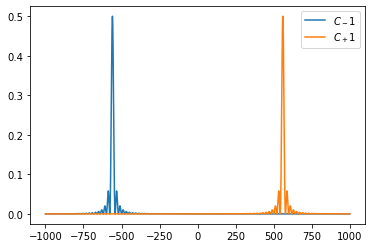

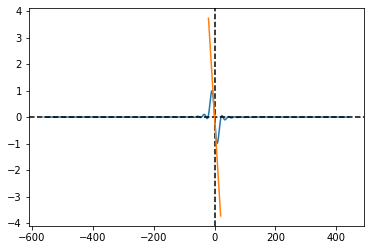

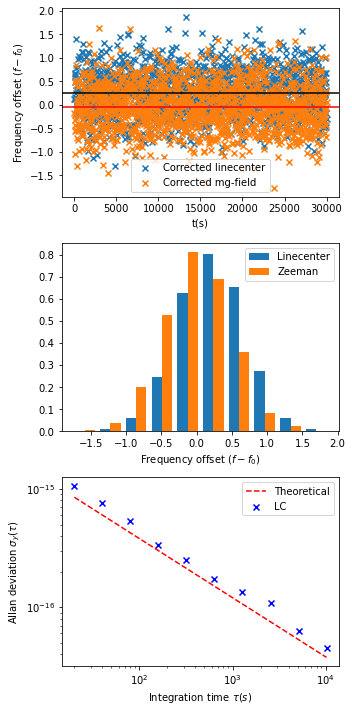

In [83]:
peak_coeffs = {'+': 0.6/0.5,
               '-': 0.4/0.5}
center = 0. # Hz, relative transition frequency
B = 100 # nT, magnetic field strength
B_drift = 0.01 # nT/s, B-field drift
zeeman_coeff = 5.6 # Hz/nT, Zeeman peak coefficient
linear_zeeman = lambda B: zeeman_coeff*B
z_s = linear_zeeman(B) # initial linear Zeeman shift
tau_pi = 50e-3 # Pi-pulse length
n_s = 100 # number of samples
T_c = 2*tau_pi # s, single cycle length
T_s = n_s * T_c # s, total sampling time
initial_offset = 0 # Hz
state_preparation = False
max_tau = 30000 # s, max integration time
n_c = 2 # number of cycles per correction
laser_drift = 20e-3 # Hz/s
f0 = 444779044095486.5 # Hz, Sr88 SRS
t = np.arange(start=0, stop=max_tau+n_c*T_s, step=n_c*T_s)
eta_cavity = np.zeros(len(t)) # cavity frequency
eta_B = np.zeros(len(t)) # Zeeman peak separation servo
eta_C = np.zeros(len(t)) # Line center serco
B_field = np.zeros(len(t))
B_field[0] = B
d, step = np.linspace(-1000, 1000, 100000, retstep=True)
d_sample = np.linspace(-1000, 1000, 10)

# initialize centers, k_ps and gains
f_cavity = 0. # laser initially in the center
f_centers = np.zeros(n_c)
servo_gains = np.zeros(2)
fwhms = np.zeros(n_c)
coeffs = [-1,1]
taus = np.zeros(n_c)
for center in range(len(coeffs)):
    # sample ideal lineshape
    fourier_limit = 0.8 / tau_pi
    d_sample = np.linspace(coeffs[center]*z_s-2.*fourier_limit,
                           coeffs[center]*z_s+2.*fourier_limit, 20)
    l_sample = sampled_lineshape(lineshape, 
                                 d_sample,
                                 tau_pi=tau_pi,
                                 state_prep=state_preparation,
                                 samples_per_point=100,
                                 linecenter=coeffs[center]*z_s)
    # fit to sampled to simulate real measurement
    popt, pcov = curve_fit(lambda d, t, c: lineshape(d, t, False, c), d_sample,
                           l_sample, p0=[tau_pi, coeffs[center]*z_s])
    fit_shape = lineshape(d, popt[0], state_preparation, popt[1])
    plt.plot(d,fit_shape,label=rf'$C_{coeffs[center]:+}$')
    # calculate FWHM
    width = peak_widths(fit_shape, [np.argmax(fit_shape)], rel_height=0.5)
    fwhms[center] = d[int(width[3][0])] - d[int(width[2][0])]
    # save results to vector
    f_centers[center] = popt[1]
    taus[center] = popt[0]
plt.legend()
# set up B servo
eta_B[0] = np.mean(np.abs(f_centers))
seps, sep_step = np.linspace(0, 1000, 10000, retstep=True)
pB_pB = lineshape(fwhms[1]/2.+seps, taus[1], center=f_centers[1])
pB_mB = lineshape(fwhms[0]/2.-seps, taus[0], center=f_centers[0])
pB_pR = lineshape(-fwhms[1]/2.+seps, taus[1], center=f_centers[1])
pB_mR = lineshape(-fwhms[0]/2.-seps, taus[0], center=f_centers[0])
p_sep1 = pB_pB + pB_mR
p_sep2 = pB_mB + pB_pR
k_B = p_sep1 - p_sep2
dk_B = np.diff(k_B) / sep_step
k_pB = dk_B[np.argmin(np.abs(seps-eta_B[0]))]
servo_gains[0] = -2 * 0.5/k_pB
fig, ax = plt.subplots()
ax.plot(seps-eta_B[0], k_B)
ax.axvline(0., color='k', linestyle='--')
ax.axhline(0., color='k', linestyle='--')
ax.plot(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)*k_pB)
#set up LC servo
pfb_pB = lineshape(f_centers[0] + fwhms[0]/2. + d, taus[0], center=f_centers[0])
pfb_mB = lineshape(f_centers[1] + fwhms[1]/2. + d, taus[1], center=f_centers[1])
pfb_pR = lineshape(f_centers[0] - fwhms[0]/2. + d, taus[0], center=f_centers[0])
pfb_mR = lineshape(f_centers[1] - fwhms[1]/2. + d, taus[1], center=f_centers[1])
pfb_1 = pfb_mR+pfb_pR
pfb_2 = pfb_mB+pfb_pB
k_C = pfb_2-pfb_1
dk_C = np.diff(k_C) / step
k_p_lc = dk_C[np.argmin(np.abs(d))]
servo_gains[1] = (-2 * 0.5)/k_p_lc
eta_C[0] = np.mean(f_centers)
print(f"B servo gain: {servo_gains[0]:.2f} Hz, LC servo gain: {servo_gains[1]:.2f} Hz")
ps = np.zeros((len(t), 6)) # container for probabilites

# Run simulation
for i in range(1, len(t)):
    tau = t[i]
    # sample probabilities. Laser drifts only once per pair as two sites are sampled simultaneously (is this a problem?)
    p_mB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]+fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=0.)
    p_pR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]-fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=laser_drift)
    p_pB, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]+eta_B[i-1]+fwhms[1]/2., linecenter=z_s, tau_pi=tau_pi, laser_drift=0.)
    p_mR, f_cavity, delta_cavity = sampling_cycle(f_cavity, T_s, n_s, eta_C[i-1]-eta_B[i-1]-fwhms[0]/2., linecenter=-z_s, tau_pi=tau_pi, laser_drift=laser_drift)
    
    # Control B servo
    p_sep1 = p_pB + p_mR
    p_sep2 = p_mB + p_pR
    discriminant_B = np.divide(p_sep1 - p_sep2, p_sep1 + p_sep2)
    eta_B[i] = eta_B[i-1] + discriminant_B * servo_gains[0]
    
    # Control LC servo
    pfb_1 = p_mR+p_pR
    pfb_2 = p_mB+p_pB
    ps[i,:] = [p_mR, p_mB, p_pR, p_pB, pfb_1, pfb_2]
    discriminant_LC = (pfb_2 - pfb_1) / (pfb_2 + pfb_1)
    eta_C[i] = eta_C[i-1] + discriminant_LC * servo_gains[1]

    eta_cavity[i] = f_cavity

    # Drift mg-field
    B_field[i] = B_field[i-1] + B_drift
    z_s = linear_zeeman(B_field[i])
    
# plot results
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
eta_corrected = eta_C + eta_cavity
ax[0].scatter(t, eta_corrected, label='Corrected linecenter', marker='x')
ax[0].scatter(t, eta_B - linear_zeeman(B_field), label='Corrected mg-field', marker='x')
ax[0].axhline(np.mean(eta_corrected), color='k')
ax[0].axhline(np.mean(eta_B - linear_zeeman(B_field)), color='r')
ax[0].set_ylabel(r"Frequency offset ($f-f_0$)")
ax[0].set_xlabel("t(s)")
ax[0].legend()
ax[1].hist([eta_corrected, eta_B - linear_zeeman(B_field)], density=True, label=['Linecenter', 'Zeeman'])
ax[1].set_xlabel(r"Frequency offset ($f-f_0$)")
ax[1].legend()
(taus, adevs, errors, ns) = allantools.oadev(eta_corrected/f0, data_type='freq', rate=1./(T_s * n_c))
theoretical_adev = allan_deviation(0.5, k_p_lc, f0, T_c, taus)
ax[2].scatter(taus, adevs, color='b', marker='x', label="LC")
ax[2].plot(taus, theoretical_adev, color='r', linestyle='--', label="Theoretical")
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].set_ylabel(r"Allan deviation $\sigma_y(\tau)$")
ax[2].set_xlabel(r"Integration time $\tau (s)$")
ax[2].legend()
fig.tight_layout()

In [20]:
dk_B[np.argmin(np.abs(seps-eta_B[0]))]

IndexError: index 9999 is out of bounds for axis 0 with size 9999

In [29]:
popt

array([4.95037320e-02, 1.40389448e+03])

In [27]:
Bs

[array([100.  , 100.01, 100.02, ..., 249.98, 249.99, 250.  ])]

In [ ]:

# test with biased pairs
# test with multiple biased pairs

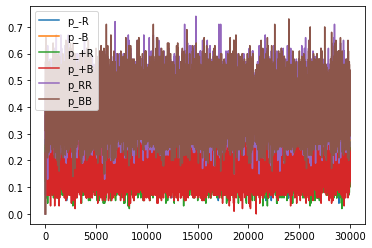

In [44]:
plt.plot(t, ps[:, 0], label='p_-R')
plt.plot(t, ps[:, 1], label='p_-B')
plt.plot(t, ps[:, 2], label='p_+R')
plt.plot(t, ps[:, 3], label='p_+B')
plt.plot(t, ps[:, 4], label='p_RR')
plt.plot(t, ps[:, 5], label='p_BB')
plt.legend()
#plt.xlim([0, 4000])

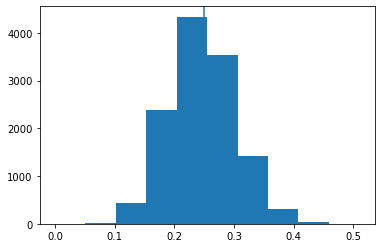

In [56]:
plt.hist(ps[:, 1])
plt.axvline(.25)

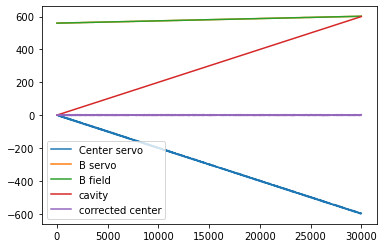

In [63]:
plt.plot(t, eta_C, label='Center servo')
plt.plot(t, eta_B, label='B servo')
plt.plot(t, linear_zeeman(B_field), label='B field')
plt.plot(t, eta_cavity, label='cavity')
plt.plot(t, eta_cavity+eta_C, label='corrected center')
plt.legend()

# 2020-08-21 Measurement result

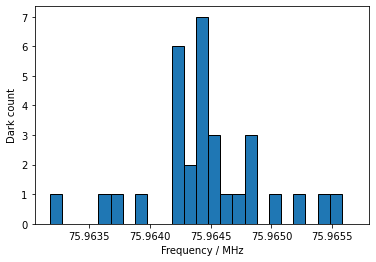

In [93]:
df_init = pd.read_csv('../data/BC_init.csv', header=None)
df_init.columns = ['f', 'dc']
df_init = df_init.sort_values(by='f')
plt.bar(x=df_init['f'], height=df_init['dc'], width=0.0001, edgecolor='k')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('Frequency / MHz')
plt.ylabel('Dark count')
plt.savefig('../figs/BC_init.pdf', dpi=150)

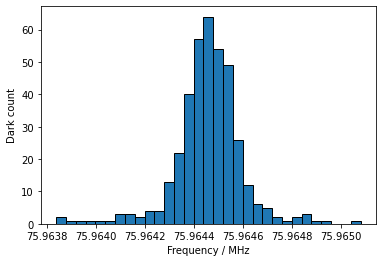

In [101]:
df_res = pd.read_csv('../data/BC_res.csv', header=None)
df_res.columns = ['f', 'dc']
df_res = df_res.sort_values(by='f')
plt.bar(x=df_res['f'], height=df_res['dc'], width=0.00004, edgecolor='k')
plt.gca().ticklabel_format(useOffset=False)
plt.xlabel('Frequency / MHz')
plt.ylabel('Dark count')
plt.savefig('../figs/BC_res.pdf', dpi=150)